In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from IPython.display import Audio, display
from skimage.transform import resize
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [9]:
data_path = "data/genres_original"
genres = os.listdir(data_path)

genres = os.listdir(data_path)
for genre in genres:
    print(f"Genre: {genre}")
    genre_path = os.path.join(data_path, genre)
    # Check if the path is a directory before listing contents
    if os.path.isdir(genre_path):
        files = os.listdir(genre_path)
        print(f"Number of files: {len(files)}")
    else:
        print(f"Skipped: {genre} is not a directory.")

Genre: pop
Number of files: 100
Genre: .DS_Store
Skipped: .DS_Store is not a directory.
Genre: metal
Number of files: 100
Genre: disco
Number of files: 100
Genre: blues
Number of files: 100
Genre: reggae
Number of files: 100
Genre: classical
Number of files: 100
Genre: rock
Number of files: 100
Genre: hiphop
Number of files: 100
Genre: country
Number of files: 100
Genre: jazz
Number of files: 100


### Mel Spectrogram Visualisation for each Genre (first audio file)

Genre: blues
Selected file: blues.00000.wav
Mel Spectrogram dimensions: (128, 1293)
Mel Spectrogram range: 3.3099714080719878e-09 to 2646.10595703125 dB
--------------------------------------------------
Genre: classical
Selected file: classical.00000.wav
Mel Spectrogram dimensions: (128, 1293)
Mel Spectrogram range: 2.6526347784994186e-09 to 188.32415771484375 dB
--------------------------------------------------
Genre: country
Selected file: country.00000.wav
Mel Spectrogram dimensions: (128, 1296)
Mel Spectrogram range: 0.00016271279309876263 to 1573.6378173828125 dB
--------------------------------------------------
Genre: disco
Selected file: disco.00000.wav
Mel Spectrogram dimensions: (128, 1298)
Mel Spectrogram range: 3.177125472575426e-05 to 1337.1080322265625 dB
--------------------------------------------------
Genre: hiphop
Selected file: hiphop.00000.wav
Mel Spectrogram dimensions: (128, 1293)
Mel Spectrogram range: 3.215603783246479e-09 to 686.56103515625 dB
--------------

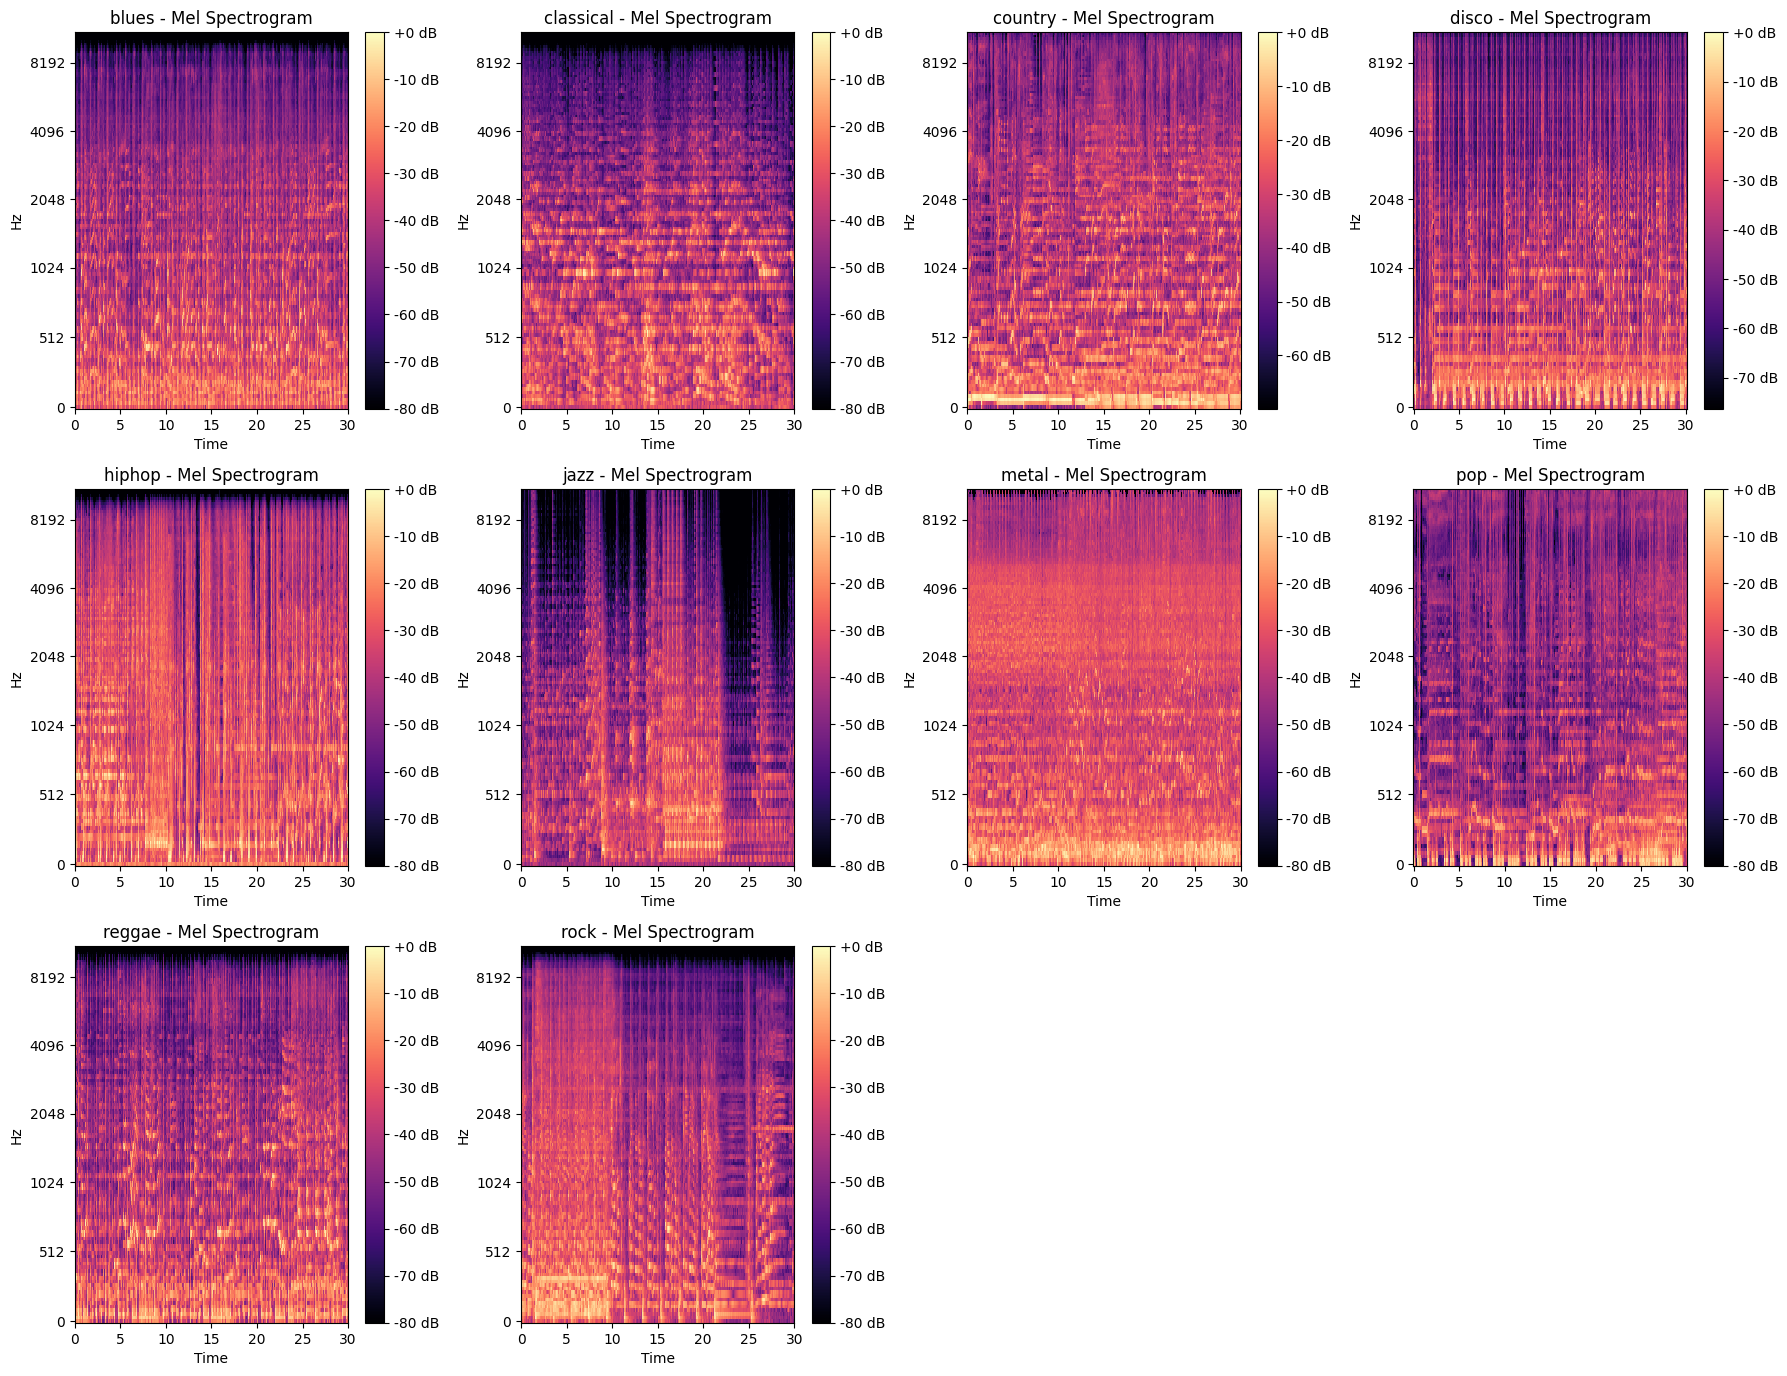

In [5]:
figure, axs = plt.subplots(nrows=4, ncols=4, figsize=(18, 18))
axs = axs.ravel()

for index, genre in enumerate(genres):
    # construct the file paths and load the first audio file for the genre
    path_to_genre = os.path.join(data_path, genre)
    first_file = os.listdir(path_to_genre)[0]
    audio_path = os.path.join(path_to_genre, first_file)
    audio_data, sampling_rate = librosa.load(audio_path)

    # compute the Mel Spectrogram and convert to decibels
    spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sampling_rate)
    spectrogram_in_db = librosa.power_to_db(spectrogram, ref=np.max)

    librosa.display.specshow(spectrogram_in_db, ax=axs[index], y_axis='mel', x_axis='time')
    axs[index].set(title=f"{genre} - Mel Spectrogram")
    fig_colorbar = plt.colorbar(axs[index].collections[0], ax=axs[index], format='%+2.0f dB')

    print(f"Genre: {genre}")
    print(f"Selected file: {os.path.basename(audio_path)}")
    print(f"Mel Spectrogram dimensions: {spectrogram.shape}")
    print(f"Mel Spectrogram range: {np.min(spectrogram)} to {np.max(spectrogram)} dB")
    print("-" * 50)

# deactivate unused axs
for j in range(len(genres), 16):
    axs[j].set_visible(False)

figure.tight_layout()
plt.show()

### Breakdown

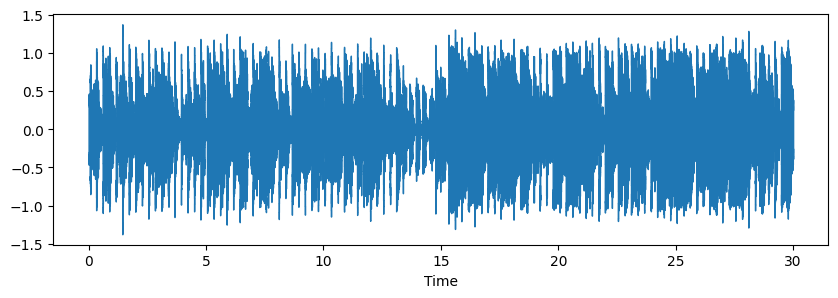

In [6]:
# visualisation of a single file
random_file_path = 'data/genres_original/pop/pop.00020.wav'

x, sr = librosa.load(random_file_path, sr=44100)
display(Audio(data=x, rate=sr))

plt.figure(figsize=(10, 3))
librosa.display.waveshow(x, sr=sr);

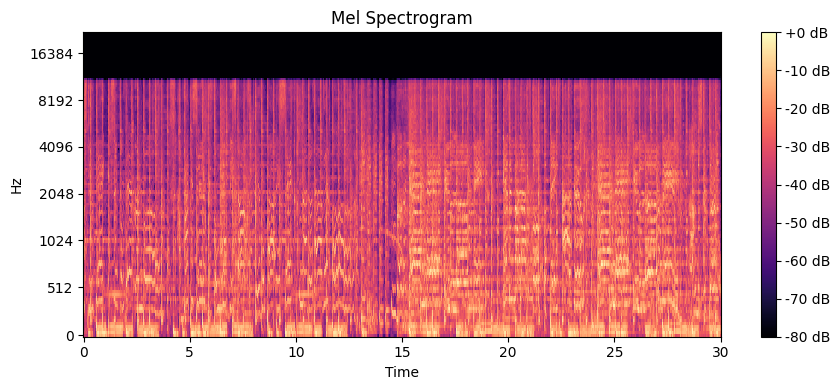

In [7]:
def create_mel_spectrogram(y, sr):

    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    plt.figure(figsize=(9, 4))
    librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
    plt.title('Mel Spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

create_mel_spectrogram(x, sr)

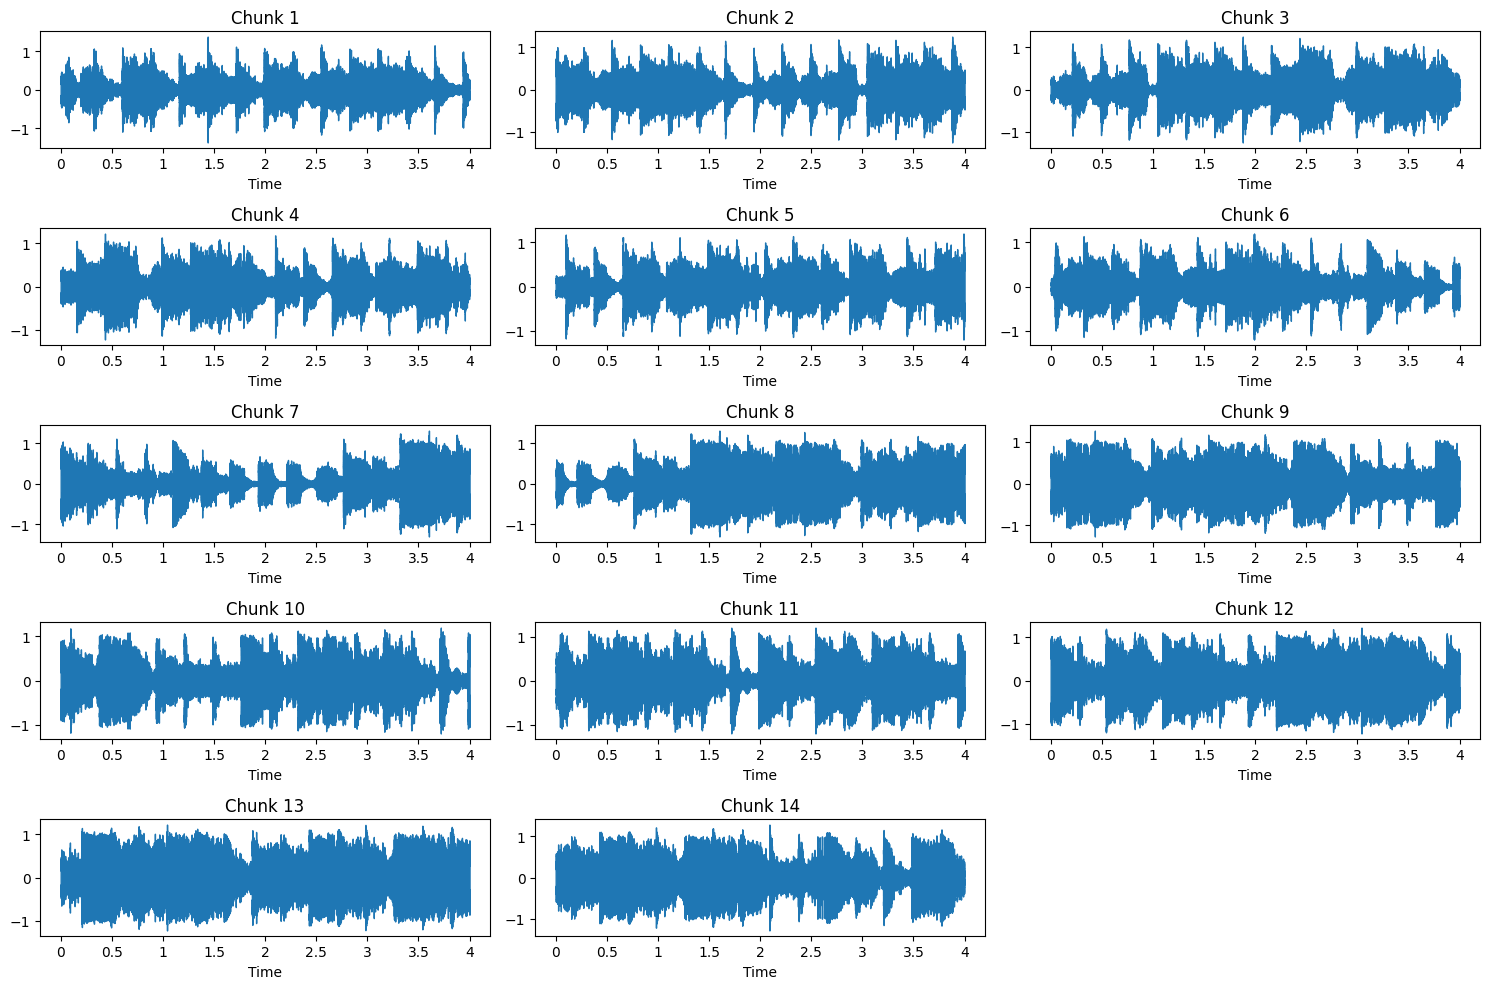

In [8]:
# we segment the audio file into chunks of 4 seconds with overlap of 2 seconds

segment_length = 4 * sr  # 4 seconds
overlap = 2 * sr  # 2 seconds
step = segment_length - overlap

# calculate the number of segments
segments = range(0, len(x) - segment_length + 1, step)
num_of_segments = len(segments)

# create subplots
cols = 3  
rows = (num_of_segments + cols - 1) // cols 
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 2 * rows))

for i, start in enumerate(segments):
    end = start + segment_length
    chunk = x[start:end]

    ax = axs.flatten()[i]
    ax.set_title(f'Chunk {i + 1}')
    librosa.display.waveshow(chunk, sr=sr, ax=ax)

# hide any unused subplots
if num_of_segments < rows * cols:
    for idx in range(num_of_segments, rows * cols):
        axs.flatten()[idx].set_visible(False)

plt.tight_layout()
plt.show()

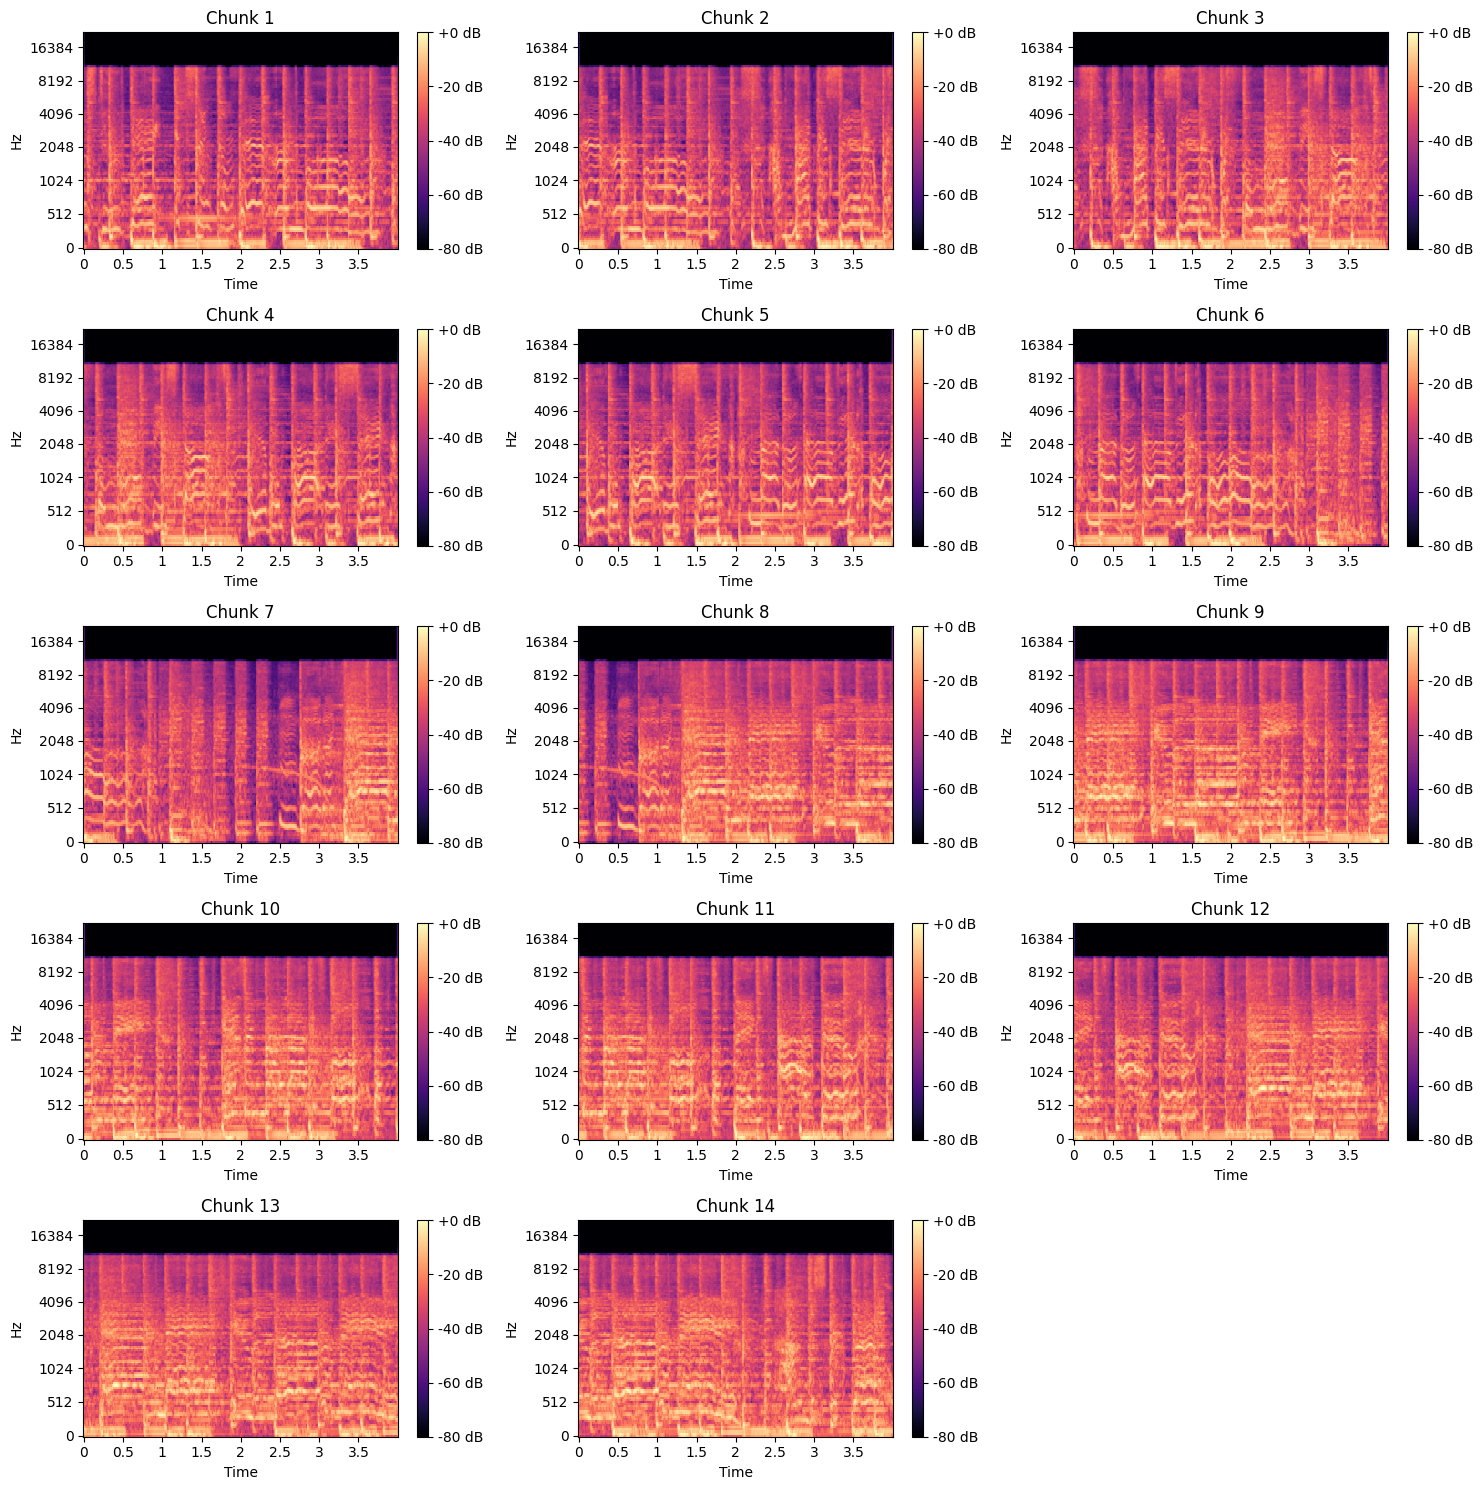

In [9]:
segment_length = 4 * sr 
overlap = 2 * sr  
step = segment_length - overlap

segments = range(0, len(x) - segment_length + 1, step)
num_of_segments = len(segments)

cols = 3  
rows = (num_of_segments + cols - 1) // cols 
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 3 * rows))

for i, start in enumerate(segments):
    end = start + segment_length
    chunk = x[start:end]

    # Compute the Mel spectrogram for the chunk
    mel_spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Plot the Mel spectrogram
    ax = axs.flatten()[i]
    ax.set_title(f'Chunk {i + 1}')
    librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel', ax=ax)
    plt.colorbar(ax.collections[0], ax=ax, format='%+2.0f dB')

# hide any unused subplots
if num_of_segments < rows * cols:
    for idx in range(num_of_segments, rows * cols):
        axs.flatten()[idx].set_visible(False)

plt.tight_layout()
plt.show()

### Pre-processing dataset

In [10]:
classes = ['blues', 'classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
directory = 'data/genres_original'

In [11]:
def normalize_peak(audio):
    return audio / np.max(np.abs(audio))

def normalize_standard(audio):
    return (audio - np.mean(audio)) / np.std(audio)

def preprocess_audio_files(directory, genres, resized_shape=(150, 150)):
    spectrograms = []
    genre_labels = []
    
    for genre_index, genre in enumerate(genres):
        print("Currently processing:", genre)
        
        genre_directory = os.path.join(directory, genre)
        for file in os.listdir(genre_directory):
            if file.lower().endswith('.wav'):
                audio_path = os.path.join(genre_directory, file)
                audio, rate = librosa.load(audio_path, sr=None)
                audio = normalize_peak(audio)  # Apply peak normalization
                
                duration_of_chunk = 4  # seconds
                overlap = 2  # seconds
                samples_per_chunk = duration_of_chunk * rate
                samples_overlap = overlap * rate
                total_chunks = int(np.ceil((len(audio) - samples_per_chunk) / (samples_per_chunk - samples_overlap))) + 1
                
                for chunk_number in range(total_chunks):
                    start_sample = chunk_number * (samples_per_chunk - samples_overlap)
                    end_sample = start_sample + samples_per_chunk
                    audio_chunk = audio[start_sample:end_sample]
                    mel_spect = librosa.feature.melspectrogram(y=audio_chunk, sr=rate)
                    resized_mel_spect = resize(np.expand_dims(mel_spect, axis=-1), resized_shape)
                    spectrograms.append(resized_mel_spect)
                    genre_labels.append(genre_index)
    
    return np.array(spectrograms), np.array(genre_labels)

In [12]:
spectrograms, genre_labels = preprocess_audio_files(directory, classes)

# Print the shape of the labels array
print("Shape of the labels array:", genre_labels.shape)

Currently processing: blues
Currently processing: classical
Currently processing: country
Currently processing: disco
Currently processing: hiphop
Currently processing: jazz
Currently processing: metal
Currently processing: pop
Currently processing: reggae
Currently processing: rock
Shape of the labels array: (14975,)


In [13]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

# one-hot encode the labels
one_hot_labels = one_hot_encode(genre_labels, len(genres))

print("Shape of the one-hot encoded labels array:", one_hot_labels.shape)
print("Example of a one-hot encoded label:", one_hot_labels[0])

Shape of the one-hot encoded labels array: (14975, 11)
Example of a one-hot encoded label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [14]:
# split data into 80% train and 20%
X_train, X_test, y_train, y_test = train_test_split(spectrograms, genre_labels, test_size=0.20, random_state=42)

# shapes of the resulting datasets
print("Shape of the training set:", X_train.shape)
print("Shape of the testing set:", X_test.shape)
print("Shape of the training labels:", y_train.shape)
print("Shape of the testing labels:", y_test.shape)

Shape of the training set: (11980, 150, 150, 1)
Shape of the testing set: (2995, 150, 150, 1)
Shape of the training labels: (11980,)
Shape of the testing labels: (2995,)


In [15]:
# Convert numpy arrays to PyTorch tensors and permute dimensions
X_train_tensor = torch.FloatTensor(X_train).permute(0, 3, 1, 2)  # (batch, channels, height, width)
X_test_tensor = torch.FloatTensor(X_test).permute(0, 3, 1, 2)   # (batch, channels, height, width)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

# Create dataset and dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### CNN + RNN (LSTM)

In [16]:
class HybridCNNRNN(nn.Module):
    def __init__(self, num_classes=10):
        super(HybridCNNRNN, self).__init__()
        
        # CNN layers
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128)
        )
        
        # Calculate the size after CNN layers
        self.feature_size = 128
        self.sequence_length = (150 // 8) * (150 // 8)  # After 3 max pooling layers
        
        # RNN layers
        self.rnn = nn.LSTM(
            input_size=128,
            hidden_size=64,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.3
        )
        
        # Dense layers
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),  # 128 because bidirectional LSTM (64*2)
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        # CNN forward pass
        x = self.cnn(x)  # Shape: (batch, channels, height, width)
        
        # Prepare for RNN
        batch_size = x.size(0)
        x = x.permute(0, 2, 3, 1)  # Shape: (batch, height, width, channels)
        x = x.reshape(batch_size, self.sequence_length, self.feature_size)  # Shape: (batch, sequence_length, features)
        
        # RNN forward pass
        x, _ = self.rnn(x)  # Shape: (batch, sequence_length, 2*hidden_size)
        
        # Use the last sequence output
        x = x[:, -1, :]  # Shape: (batch, 2*hidden_size)
        
        # Classification
        x = self.classifier(x)
        
        return x

In [17]:
# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridCNNRNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training function
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(train_loader), 100. * correct / total

# Evaluation function
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return 100. * correct / total

Epoch: 1/30
Train Loss: 1.9319 | Train Acc: 28.16%
Test Acc: 34.62%
--------------------------------------------------
Epoch: 2/30
Train Loss: 1.7126 | Train Acc: 36.97%
Test Acc: 38.96%
--------------------------------------------------
Epoch: 3/30
Train Loss: 1.6151 | Train Acc: 40.98%
Test Acc: 43.14%
--------------------------------------------------
Epoch: 4/30
Train Loss: 1.5196 | Train Acc: 43.65%
Test Acc: 43.87%
--------------------------------------------------
Epoch: 5/30
Train Loss: 1.4597 | Train Acc: 45.61%
Test Acc: 49.42%
--------------------------------------------------
Epoch: 6/30
Train Loss: 1.3988 | Train Acc: 48.46%
Test Acc: 47.81%
--------------------------------------------------
Epoch: 7/30
Train Loss: 1.3406 | Train Acc: 50.69%
Test Acc: 52.95%
--------------------------------------------------
Epoch: 8/30
Train Loss: 1.2840 | Train Acc: 53.06%
Test Acc: 55.13%
--------------------------------------------------
Epoch: 9/30
Train Loss: 1.2489 | Train Acc: 54.9

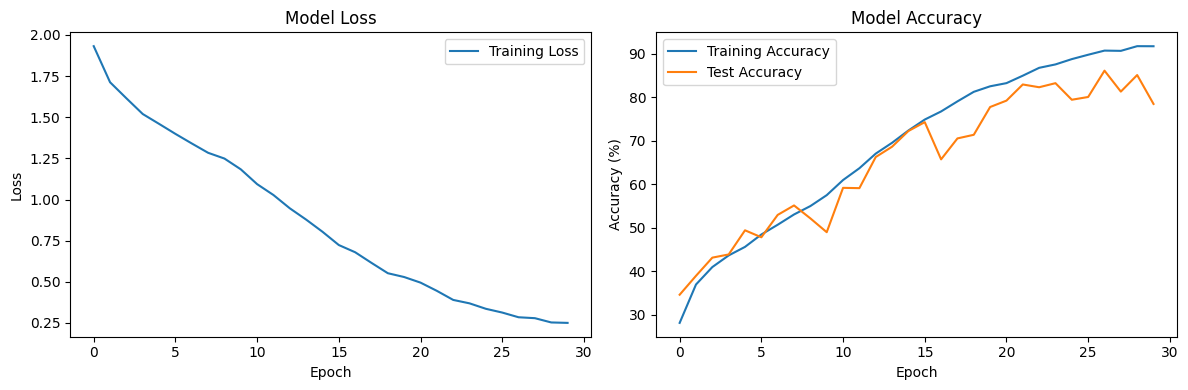

In [18]:
# Training loop
num_epochs = 30
best_acc = 0
train_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    test_acc = evaluate(model, test_loader)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    print(f'Epoch: {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Test Acc: {test_acc:.2f}%')
    print('-' * 50)
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_model.pth')

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

### CNN + RNN (GRU)

In [20]:
class HybridCNNGRU(nn.Module):
    def __init__(self, num_classes=10):
        super(HybridCNNGRU, self).__init__()
        
        # CNN layers
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128)
        )
        
        # Calculate the size after CNN layers
        self.feature_size = 128
        self.sequence_length = (150 // 8) * (150 // 8)  # After 3 max pooling layers
        
        # RNN layers with GRU
        self.rnn = nn.GRU(
            input_size=128,
            hidden_size=64,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.3
        )
        
        # Dense layers
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),  # 128 because bidirectional GRU (64*2)
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        # CNN forward pass
        x = self.cnn(x)  # Shape: (batch, channels, height, width)
        
        # Prepare for RNN
        batch_size = x.size(0)
        x = x.permute(0, 2, 3, 1)  # Shape: (batch, height, width, channels)
        x = x.reshape(batch_size, self.sequence_length, self.feature_size)  # Shape: (batch, sequence_length, features)
        
        # RNN forward pass
        x, _ = self.rnn(x)  # Shape: (batch, sequence_length, 2*hidden_size)
        
        # Use the last sequence output
        x = x[:, -1, :]  # Shape: (batch, 2*hidden_size)
        
        # Classification
        x = self.classifier(x)
        
        return x

Epoch: 1/30
Train Loss: 1.9250 | Train Acc: 27.81%
Test Acc: 24.67%
--------------------------------------------------
Epoch: 2/30
Train Loss: 1.5006 | Train Acc: 44.73%
Test Acc: 29.32%
--------------------------------------------------
Epoch: 3/30
Train Loss: 1.2649 | Train Acc: 53.72%
Test Acc: 34.76%
--------------------------------------------------
Epoch: 4/30
Train Loss: 1.0590 | Train Acc: 62.50%
Test Acc: 56.99%
--------------------------------------------------
Epoch: 5/30
Train Loss: 0.8828 | Train Acc: 69.21%
Test Acc: 57.06%
--------------------------------------------------
Epoch: 6/30
Train Loss: 0.7526 | Train Acc: 73.91%
Test Acc: 67.95%
--------------------------------------------------
Epoch: 7/30
Train Loss: 0.6273 | Train Acc: 78.62%
Test Acc: 59.73%
--------------------------------------------------
Epoch: 8/30
Train Loss: 0.5568 | Train Acc: 81.04%
Test Acc: 79.57%
--------------------------------------------------
Epoch: 9/30
Train Loss: 0.4919 | Train Acc: 83.7

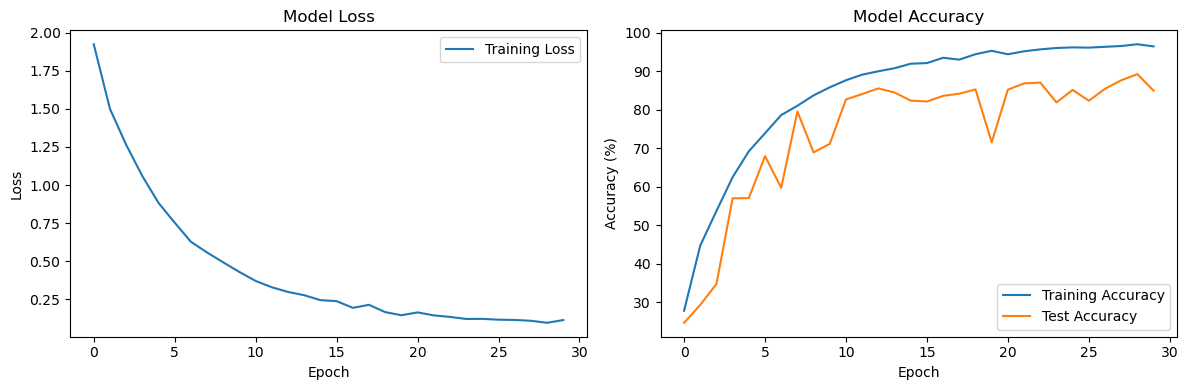

In [21]:
# Initialize new model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gru_model = HybridCNNGRU(num_classes=10).to(device)  

# Re-initialize the optimizer for the new model
optimizer = optim.Adam(gru_model.parameters())

# Training and evaluation
num_epochs = 30
best_acc = 0
train_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(gru_model, train_loader, criterion, optimizer)
    test_acc = evaluate(gru_model, test_loader)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f'Epoch: {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Test Acc: {test_acc:.2f}%')
    print('-' * 50)
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(gru_model.state_dict(), 'best_gru_model.pth')

# Plot training history 
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()